In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import ElasticNetCV, LassoCV,RidgeClassifierCV, ElasticNet, Lasso, LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
import ast

# 载入数据

In [3]:
random_num = 1
data = "./20240820 对数加一训练集和测试集.xlsx"

# 载入数据集
dataset = pd.DataFrame(pd.read_excel(data, sheet_name="训练集"))
x_train = dataset[dataset.columns[1:]]
y_train = dataset[['Group']].values.ravel()

dataset_test = pd.DataFrame(pd.read_excel(data, sheet_name="测试集"))
x_test = dataset_test[dataset_test.columns[1:]]
y_test = dataset_test[['Group']].values.ravel()

print(x_train.shape)

(300, 32)


In [3]:
feature_list = ['PCT', 'HB', 'LYM', 'CRE', 'PLT', 'DBIL', 'IBIL', 'EOS', 'MON', 'Cough'][0:5]
len(feature_list)

5

In [4]:
x_train = x_train[feature_list]
x_test = x_test[feature_list]
x_train.shape,x_test.shape

((300, 5), (190, 5))

# 模型训练

In [5]:
#模型选择，记得调整超参数
print('[1]ensemble\n[2]tree\n[3]linear\n[4]svm\n[5]bayes\n[6]logistic\n[7]neural network\n[8]neighbor')
leixing = input('请选择类型：')
if leixing == '1':
    print('[a]AdaBoost\n[b]RandomForest\n[c]GradientBoosting\n[d]ExtraTree\n[e]XGBoost')
    model_all = {'a':'AdaBoostClassifier(algorithm="SAMME.R", learning_rate= 0.18999999999999995,n_estimators=498 ,random_state=1)', #shap5
                 'b':'RandomForestClassifier(criterion= "gini", max_depth=11, max_features=0.7, n_estimators=87,random_state=1)', #32
                 'c':'GradientBoostingClassifier(learning_rate= 0.2, max_depth=5, max_features=0.16, n_estimators=96, subsample=0.79, random_state=1)', #32
                 'd':'ExtraTreesClassifier(criterion="gini", max_depth=3, max_features=0.06999999999999999,n_estimators=79, random_state=1)'} #32
                 #'e':'XGBClassifier(max_depth=1,random_state=1,seed = 1)'}
elif leixing == '2':
    print('[a]DecisionTree\n[b]ExtraTree')
    model_all = {'a':'DecisionTreeClassifier(criterion="entropy", splitter="best", max_features=7,random_state=1)',  #32
                 'b':'ExtraTreeClassifier(criterion="entropy", max_depth=4, max_features=3,splitter="random",random_state=1)'} #32
elif leixing == '3':
    print('[a]ElasticNet\n[b]LASSO\n[c]Ridge\n[d]SDG\n[e]感知机\n[f]PAC')
    model_all = {#'a': 'ElasticNetCV(random_state = random_num)', 
                 #'b': 'LassoCV(random_state = random_num)',
                'c':'RidgeClassifierCV(alphas=39.4, fit_intercept=True)',#这个模型不能设置随机数种子,32
                'd':'SGDClassifier(alpha=0.06999999999999999, fit_intercept=False, l1_ratio=0.4, learning_rate="optimal", loss="epsilon_insensitive", penalty="elasticnet", random_state=1)',#32
                'e':'Perceptron(alpha=5.9999999999999995e-05, fit_intercept=True, penalty="l2",random_state=1)',#32
                'f':'PassiveAggressiveClassifier(C=0.002, fit_intercept=True, random_state = 1)'} #32
elif leixing == '4':
    print('[a]LinearSVC\n[b]SVC\n[c]LDA')
    model_all = {'a': 'LinearSVC(C=0.01, dual=False, penalty="l2", random_state=1)', #32
                 'b': 'SVC(C=104, gamma="scale", kernel="linear", random_state=1)'} #32
                 #'c':'LinearDiscriminantAnalysis(shrinkage="auto", solver="lsqr")'}
elif leixing == '5':
    print('[a]BernoulliNB')
    model_all = {'a':'BernoulliNB(alpha=49.494949494949495, binarize=1.1111111111111112, class_prior=None, fit_prior=True)'}#这个模型不能设置随机数种子，32

model_want = input('请选择模型:')
model_out = model_all.get(model_want)
print("model_out:",model_out)

model =eval(model_out)
model.fit(x_train, y_train)

#scores = cross_val_score(model, x_train, y_train, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), n_jobs=-1, scoring='roc_auc', verbose=0)
#print('五折train_AUC:', scores.mean())
#scores_acc = cross_val_score(model, x_train, y_train.values.ravel(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), n_jobs=-1, scoring='accuracy', verbose=0)
#print('五折train_ACC:', scores_acc.mean())
scores_f1 = cross_val_score(model, x_train, y_train, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), n_jobs=-1, scoring='f1', verbose=0)
print('五折train_f1:', scores_f1.mean())

if leixing == '3' or leixing == '4':
    y_pred_train = model.decision_function(x_train)
    y_pred_test = model.decision_function(x_test)
    # 根据阈值将预测结果转换为二进制标签
    y_pred_train_binary = (y_pred_train > 0).astype(int)
    y_pred_test_binary = (y_pred_test > 0).astype(int)
    
else:    
    y_pred_train = model.predict_proba(x_train)[:, 1]
    y_pred_test = model.predict_proba(x_test)[:, 1]
    # 选择默认阈值为0.5来转换预测概率为二进制标签
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

auc_train = roc_auc_score(y_train, y_pred_train)
acc_train = accuracy_score(y_train, model.predict(x_train))
f1_train = f1_score(y_train, y_pred_train_binary)

auc_test = roc_auc_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, model.predict(x_test))
f1_test = f1_score(y_test, y_pred_test_binary)

print('训练集AUC:', auc_train)
print('训练集ACC:', acc_train)
print('训练集F1分数:', f1_train)

print('测试集AUC:', auc_test)
print('测试集ACC:', acc_test)
print('测试集F1分数:', f1_test)

[1]ensemble
[2]tree
[3]linear
[4]svm
[5]bayes
[6]logistic
[7]neural network
[8]neighbor
[a]AdaBoost
[b]RandomForest
[c]GradientBoosting
[d]ExtraTree
[e]XGBoost
model_out: AdaBoostClassifier(algorithm="SAMME.R", learning_rate= 0.18999999999999995,n_estimators=498 ,random_state=1)
五折train_f1: 0.9096258122680692
训练集AUC: 0.9963235294117647
训练集ACC: 0.96
训练集F1分数: 0.9747899159663865
测试集AUC: 0.7598913228052301
测试集ACC: 0.8368421052631579
测试集F1分数: 0.9015873015873016


# 概率分布散点图

In [1]:
import seaborn as sns

In [ ]:
dataset_name = '32特征最优模型'
transformed_X_train = model.predict_proba(x_train)
transformed_X_test = model.predict_proba(x_test)
transformed_X_train.shape

In [ ]:
# 假设 new_features 是模型产生的二维特征，y_train 是标签
# 将二维特征和标签结合成 DataFrame
feature_df = pd.DataFrame(transformed_X_train, columns=['prob0', 'prob1'])
feature_df['Group'] = y_train  # 添加标签列
feature_df['Sample_Index'] = feature_df.index
feature_df.drop(columns='prob0', inplace=True)
feature_df.head()

In [ ]:
# 绘制概率分布散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Sample_Index', y='prob1', hue='Group', data=feature_df, palette='Set1', s=100, edgecolor=None,facecolors='none')
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5)  # 添加水平虚线
plt.title('test')
plt.xlabel('Sample_Index')
plt.ylabel('prob1')
plt.legend(title='Group')
plt.grid(True)
#plt.savefig('32-train.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制概率分布散点图
plt.figure(figsize=(8, 6))

# 使用 scatter 绘制空心圆圈并根据 Group 着色
for name, group in feature_df.groupby('Group'):
    plt.scatter(
        group.index, group['prob1'],
        s=100, facecolors='none', edgecolors=sns.color_palette('Set1')[name],
        alpha=0.8, label=f'Group {name}', linewidth=1.2
    )

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5)  # 添加水平虚线
plt.title('test')
plt.xlabel('Sample_Index')
plt.ylabel('Class_1_Probability')
plt.legend(title='Group')
plt.grid(True)
#plt.savefig('32-train.png', dpi=300, bbox_inches='tight')
plt.show()


# 决策边界

In [6]:
from sklearn.decomposition import PCA  

/home/louhao/.conda/envs/mnf/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_1212680/2641557340.py:55: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_test_0 = plt.scatter(X_low_dim2.iloc[y_test == 0, 0],
/tmp/ipykernel_1212680/2641557340.py:59: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_test_1 = plt.scatter(X_low_dim2.iloc[y_test == 1, 0],
/tmp/ipykernel_1212680/2641557340.py:71: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.savefig(f'决策边界（十六支队）/{dataset}_decision_boundary.png', dpi=300)  # 保存图像
/tmp/ipyke

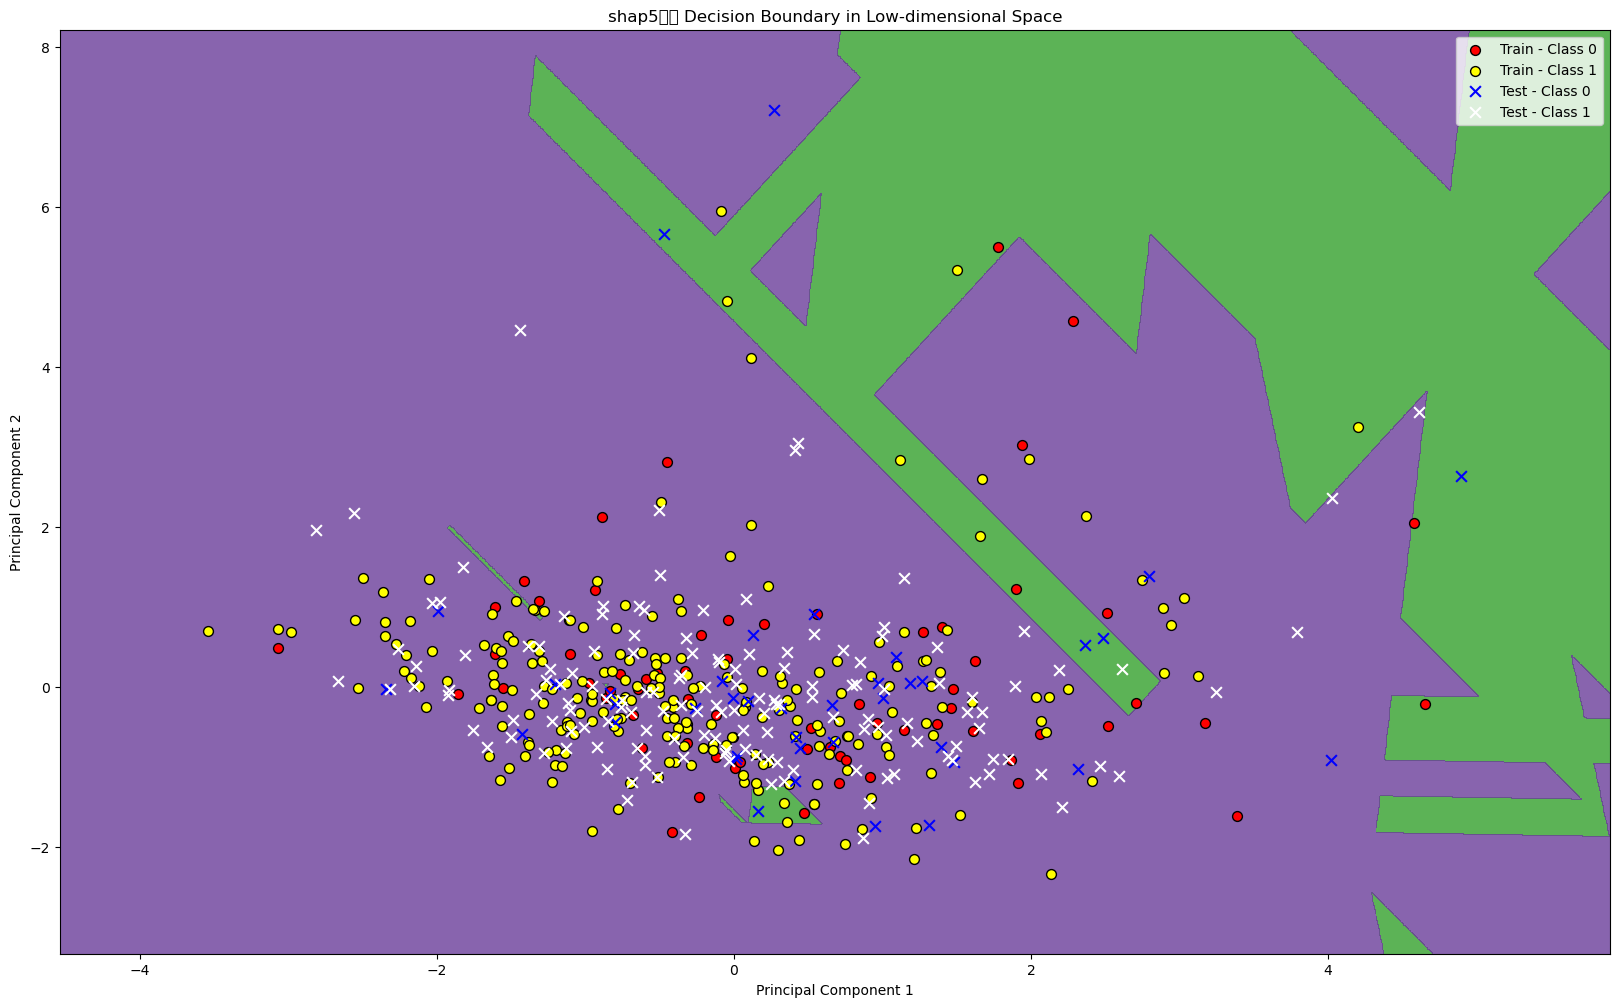

In [7]:
dataset = 'shap5特征'
# 合并两个数据集
X_high_dim_combined = np.vstack([x_train, x_test])
y_true_combined = np.hstack([y_train, y_test])

# 1. 使用PCA进行降维
pca = PCA(n_components=2)  # 创建PCA对象，将数据降到2维
X_low_dim_combined = pca.fit_transform(X_high_dim_combined)  # 使用PCA将高维数据降到2维

# 分别获取两个数据集在降维空间中的坐标
X_low_dim1 = pd.DataFrame(X_low_dim_combined[:len(x_train)])
X_low_dim2 = pd.DataFrame(X_low_dim_combined[len(x_train):])


# 2. 确定网格范围
margin = 1  # 设置边距大小，确保图形边界外留出一定空白
x_min, x_max = X_low_dim_combined[:, 0].min() - margin, X_low_dim_combined[:, 0].max() + margin  # 计算第一主成分的最小和最大值，并加上边距
y_min, y_max = X_low_dim_combined[:, 1].min() - margin, X_low_dim_combined[:, 1].max() + margin  # 计算第二主成分的最小和最大值，并加上边距

# 3. 创建低维网格点
grid_size = 2000  # 设置网格密度，即在每个维度上生成2000个网格点
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size))  # 生成x和y轴上的网格点
grid_points_low_dim = np.c_[xx.ravel(), yy.ravel()]  # 将网格点展平成二维数组，用于后续计算

# 4. 逆映射网格点至高维空间
grid_points_high_dim = pca.inverse_transform(grid_points_low_dim)  # 使用PCA的逆变换将低维网格点映射回高维空间

# 5. 模型预测
predictions = model.predict(grid_points_high_dim)  # 使用训练好的模型对高维空间中的网格点进行分类预测
Z = predictions.reshape(xx.shape)  # 将预测结果reshape为与网格形状相同，以便后续绘图

# 6. 绘制决策边界
num_classes = len(np.unique(y_true_combined))  # 获取数据集中类别的数量
plt.figure(figsize=(20, 12))
plt.contourf(xx, yy, Z, levels=np.arange(num_classes + 1) - 0.5, cmap=plt.cm.Paired, alpha=0.8)  


# 使用contourf绘制决策边界，采用不同颜色填充每个类别的区域
# 绘制原始数据点
# 定义颜色，分别对应类别 0 和 1
colors_train = ['red', 'yellow']  # 训练集类别 0 用红色，类别 1 用蓝色
colors_zheyi = ['blue', 'white']  # 验证集类别 0 用绿色，类别 1 用紫色

# 绘制训练集类别 0 和 1
scatter_train_0 = plt.scatter(X_low_dim1.iloc[y_train == 0, 0],
                              X_low_dim1.iloc[y_train == 0, 1],
                              color=colors_train[0], edgecolor='k', s=50, label='Train - Class 0')  # 点的大小 s=20

scatter_train_1 = plt.scatter(X_low_dim1.iloc[y_train == 1, 0],
                              X_low_dim1.iloc[y_train == 1, 1],
                              color=colors_train[1], edgecolor='k', s=50, label='Train - Class 1')

# 绘制验证集类别 0 和 1
scatter_test_0 = plt.scatter(X_low_dim2.iloc[y_test == 0, 0],
                              X_low_dim2.iloc[y_test == 0, 1],
                              color=colors_zheyi[0], edgecolor='k', marker='x', s=60, label='Test - Class 0')

scatter_test_1 = plt.scatter(X_low_dim2.iloc[y_test == 1, 0],
                              X_low_dim2.iloc[y_test == 1, 1],
                              color=colors_zheyi[1], edgecolor='k', marker='x', s=60, label='Test - Class 1')

# 绘制降维后的数据点，使用不同颜色表示不同类别
# 添加图形元素
plt.xlabel('Principal Component 1')  # 设置x轴标签为"第一主成分"
plt.ylabel('Principal Component 2')  # 设置y轴标签为"第二主成分"

#model_name = type(model).__name__  # 获取模型类名
plt.title(f'{dataset} Decision Boundary in Low-dimensional Space')  # 设置图形标题为"低维空间中的决策边界"
plt.legend()  # 确保图例显示
plt.savefig(f'决策边界（十六支队）/{dataset}_decision_boundary.png', dpi=300)  # 保存图像

plt.show()  # 显示绘制的图形
#保存数据
#model_name = type(model).__name__  # 获取模型类名
# 保存 predictions
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df.to_csv(f'决策边界（十六支队）/{dataset}_predictions.csv', index=False)

# 保存X_low_dim1 和 X_low_dim2

X_low_dim_combined = pd.DataFrame(X_low_dim_combined)
X_low_dim1.to_csv(f'决策边界（十六支队）/{dataset}_X_low_dim_train.csv', index=False)
X_low_dim2.to_csv(f'决策边界（十六支队）/{dataset}_X_low_dim_test.csv', index=False)

# shap

In [84]:
import shap

In [161]:
model.fit(x_train, y_train.values.ravel().astype('int'))
explainer = shap.Explainer(model.predict,x_train, random_state=1)
shap_values = explainer(x_train) 

In [162]:
# 将 SHAP 值保存到文件
with open('./十六支队shap结果/SGDClassifier/shap_values.pkl', 'wb') as f: #修改名称
    pickle.dump(shap_values, f)

In [159]:
# 从文件中读取 SHAP 值
with open('./十六支队shap结果/SGDClassifier/shap_values.pkl', 'rb') as f: # 修改名称
    shap_values = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './十六支队shap结果/SGDClassifier/shap_values.pkl'

In [163]:
shap_values_array = shap_values.values  # 取出 SHAP 值数组
feature_names = x_train.columns  # 特征名称，假设 x_train 是 pandas DataFrame

# 将 SHAP 值数组转换为 DataFrame
shap_df = pd.DataFrame(shap_values_array, columns=feature_names)

# 如果需要，也可以保存为 Excel 文件
shap_df.to_excel('./十六支队shap结果/SGDClassifier/shap_values.xlsx', index=False)

## bar plot

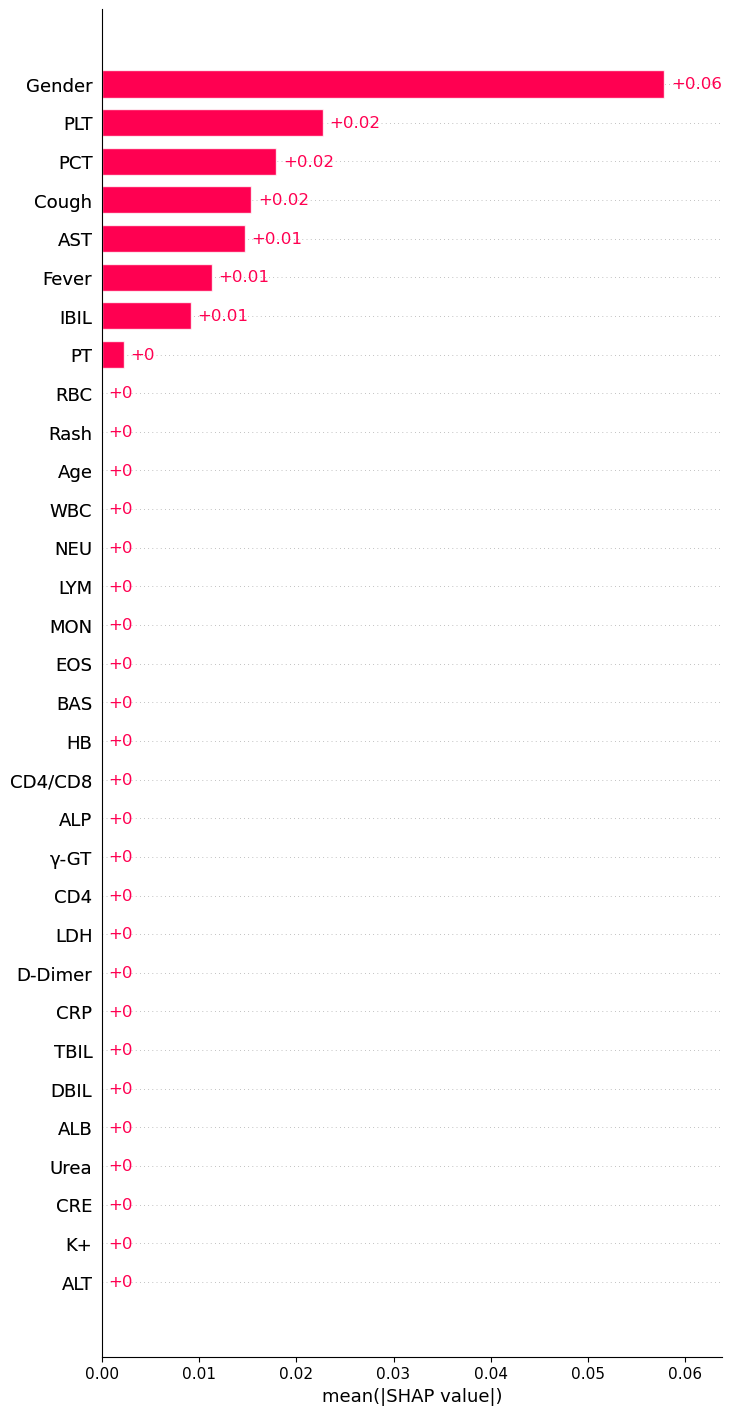

In [164]:
shap.plots.bar(shap_values, max_display=32, show=False)#max_display代表图表最大输出多少个项目
#plt.savefig('./十六支队shap结果/SVC/bar_plot.png', dpi=300)
#plt.savefig('./十六支队shap结果/AdaBoostClassifier/bar_plot.svg')
plt.show()

In [165]:
# 计算每个特征的绝对 SHAP 值的均值
shap_values_abs_mean = np.abs(shap_values.values).mean(axis=0)

# 获取特征名称
feature_names = x_train.columns

# 创建 DataFrame 来保存 SHAP 重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': shap_values_abs_mean
})

# 按 SHAP 重要性排序
rank_df = importance_df
rank_df["rank"] = rank_df['SHAP Importance'].rank(ascending=False)

importance_df = importance_df.sort_values(by='SHAP Importance', ascending=False)
importance_df
# 保存 SHAP 重要性到 Excel 文件
rank_df.to_excel('./十六支队shap结果/SGDClassifier/shap_rank.xlsx', index=False)
importance_df.to_excel('./十六支队shap结果/SGDClassifier/shap_importance_abs_mean.xlsx', index=False)

In [166]:
importance_df['Feature'].tolist()[0:10]

['Gender', 'PLT', 'PCT', 'Cough', 'AST', 'Fever', 'IBIL', 'PT', 'Rash', 'CRP']

In [44]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': shap_values_abs_mean
})
importance_df

,Feature,SHAP Importance
0,Gender,0.000740
1,Fever,0.000138
2,Cough,0.001626
3,Rash,0.000810
4,Age,0.000462
5,WBC,0.001874
6,NEU,0.001855
7,LYM,0.000695
8,MON,0.000233
9,EOS,0.000681


# permutation

In [80]:
f1_scorer = make_scorer(f1_score, average='binary')
result = permutation_importance(model, x_train, y_train, n_repeats=10,random_state=1, scoring=f1_scorer)
output = pd.DataFrame({'feature_name':x_train.columns.tolist(),'importances_mean':result['importances_mean']})
#pd.options.display.float_format = '{:.4f}'.format
output = output.sort_values(by='importances_mean', ascending=False)
#output.to_csv(r"C:\Users\15088\Desktop\循环结果.csv", header=1, index=0)
output

,feature_name,importances_mean
6,NEU,0.087500
5,WBC,0.087270
15,AST,0.035748
21,DBIL,0.032089
17,LDH,0.024461
20,TBIL,0.023638
31,PCT,0.022242
7,LYM,0.016151
28,CD4/CD8,0.007429
23,ALB,0.006164


In [81]:
print(output['feature_name'].tolist()[0:10])

['NEU', 'WBC', 'AST', 'DBIL', 'LDH', 'TBIL', 'PCT', 'LYM', 'CD4/CD8', 'ALB']


In [82]:
output = output.sort_values(by='importances_mean', ascending=False)
output.to_excel('./十六支队permutation结果/SVC/permutation_importance.xlsx', index=False)

In [24]:
import pandas as pd

# 1. 读取 Excel 文件为 DataFrame
file_path = '/Users/louhao/Desktop/马尼菲预测模型/十六支队permutation结果/SGDClassifier/permutation_importance.xlsx'
df = pd.read_excel(file_path)  # 读取文件


# 2. 根据第二列 'Value' 生成排名，作为第三列 'Rank'
df['rank'] = df['importances_mean'].rank(ascending=False, method='min')  # 使用降序排名，值大的排名高

# 3. 根据指定的列表对行进行排列
# 假设有一个指定的特征名称列表
specified_order = x_train.columns.tolist()
df = df.set_index('feature_name')  # 将 'Feature' 列设置为索引
df = df.loc[specified_order]  # 按指定列表排序

# 如果你不希望 'Feature' 列为索引，可以将其重置回列
df = df.reset_index()

# 输出处理后的 DataFrame
df.to_excel('./十六支队permutation结果/SGDClassifier/permutation_rank.xlsx', index=False)

# heatmap

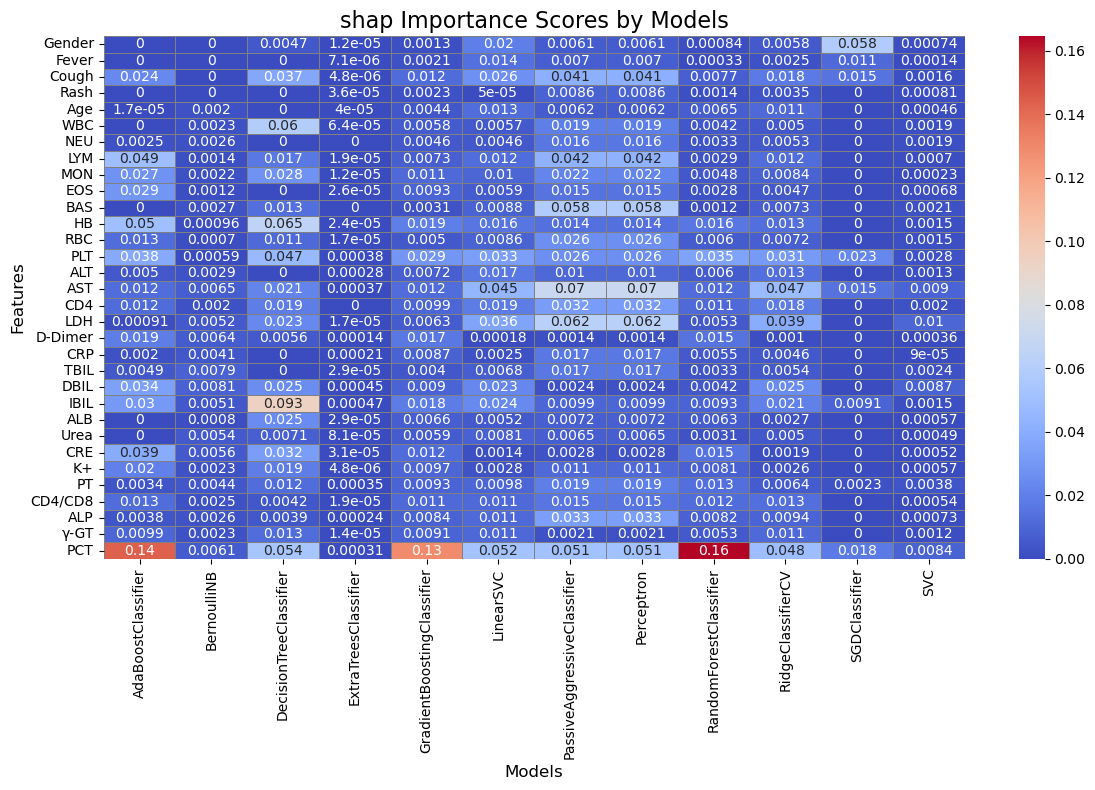

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 读取 Excel 文件
file_path = '/Users/louhao/Desktop/十六支队更新数据/12模型32特征评分.xlsx'
df = pd.read_excel(file_path, index_col=0, sheet_name = 'shap')  # 将第一列作为索引，即特征名称

# 2. 绘制热图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 使用 seaborn 的 heatmap 绘制热图
sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='gray')

# 3. 添加标题和轴标签
plt.title('shap Importance Scores by Models', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Features', fontsize=12)

# 4. 显示热图
plt.tight_layout()  # 自动调整布局以避免重叠
plt.savefig('shap_importance_heatmap.png', dpi=300, bbox_inches='tight')  # 指定保存路径和分辨率
plt.show()


# PR曲线

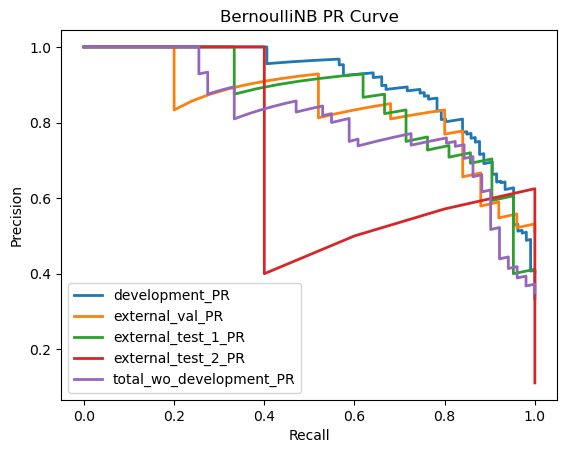

In [39]:
# 计算 Precision-Recall 曲线及其对应的阈值）
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred)
precision_test_1, recall_test_1, thresholds_test_1 = precision_recall_curve(y_test_1, y_pred_1)
#precision_test_2, recall_test_2, thresholds_test_2 = precision_recall_curve(y_test_2, y_pred_2)
#precision_test_3, recall_test_3, thresholds_test_3 = precision_recall_curve(y_test_3, y_pred_3)
#precision_test_5, recall_test_5, thresholds_test_5 = precision_recall_curve(y_test_5, y_pred_5)

# 绘制PR曲线函数
def plot_pr_curve(precision, recall, label):
    plt.plot(recall, precision, lw=2, label=label)

# 绘制PR曲线
plt.figure()
plot_pr_curve(precision_train, recall_train, 'development_PR')
plot_pr_curve(precision_test_2, recall_test_2, 'external_val_PR')
#plot_pr_curve(precision_test_3, recall_test_3, 'external_test_1_PR')
#plot_pr_curve(precision_test_1, recall_test_1, 'external_test_2_PR')
#plot_pr_curve(precision_test_5, recall_test_5, 'total_wo_development_PR')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('BernoulliNB PR Curve') #修改名称
plt.legend(loc="lower left")

# 保存图像到文件夹
plt.savefig('./output/PR曲线及其数据/图片/BernoulliNB.png') #修改名称
plt.show()

# 将 Precision、Recall 和阈值保存为 Excel
pr_data_train = pd.DataFrame({
    #'Threshold': np.append(thresholds_train, 1),  # thresholds 数量少一个，补齐
    'Precision': precision_train,
    'Recall': recall_train
})

pr_data_test_1 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_1, 1),
    'Precision': precision_test_1,
    'Recall': recall_test_1
})

pr_data_test_2 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_2, 1),
    'Precision': precision_test_2,
    'Recall': recall_test_2
})

pr_data_test_3 = pd.DataFrame({
   # 'Threshold': np.append(thresholds_test_3, 1),
    'Precision': precision_test_3,
    'Recall': recall_test_3
})

pr_data_test_5 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_5, 1),
    'Precision': precision_test_5,
    'Recall': recall_test_5
})

# 将不同数据集的 PR 曲线坐标保存到 Excel 文件的不同 sheet
with pd.ExcelWriter('./output/PR曲线及其数据/数据/BernoulliNB.xlsx') as writer: #修改名称
    pr_data_train.to_excel(writer, sheet_name='development_PR', index=False)
    pr_data_test_2.to_excel(writer, sheet_name='external_val_PR', index=False)
    pr_data_test_3.to_excel(writer, sheet_name='external_test_1_PR', index=False)
    pr_data_test_1.to_excel(writer, sheet_name='external_test_2_PR', index=False)
    pr_data_test_5.to_excel(writer, sheet_name='total_wo_development_PR', index=False)


# ROC曲线

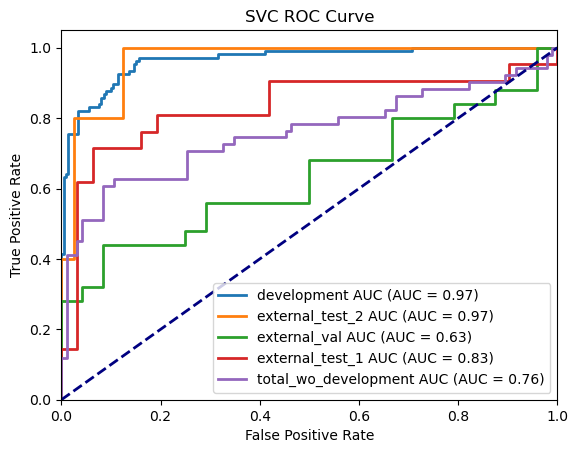

In [29]:
# 绘制ROC曲线函数
def plot_roc_curve(fpr, tpr, roc_auc, label):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# 计算ROC曲线和AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred)
fpr_test_1, tpr_test_1, _ = roc_curve(y_test_1, y_pred_1)
fpr_test_2, tpr_test_2, _ = roc_curve(y_test_2, y_pred_2)
fpr_test_3, tpr_test_3, _ = roc_curve(y_test_3, y_pred_3)
fpr_test_5, tpr_test_5, _ = roc_curve(y_test_5, y_pred_5)

# 保存ROC坐标到Excel
df_roc_train = pd.DataFrame({'FPR': fpr_train, 'TPR': tpr_train})
df_roc_test_1 = pd.DataFrame({'FPR': fpr_test_1, 'TPR': tpr_test_1})
df_roc_test_2 = pd.DataFrame({'FPR': fpr_test_2, 'TPR': tpr_test_2})
df_roc_test_3 = pd.DataFrame({'FPR': fpr_test_3, 'TPR': tpr_test_3})
df_roc_test_5 = pd.DataFrame({'FPR': fpr_test_5, 'TPR': tpr_test_5})

with pd.ExcelWriter('./output/ROC曲线及其坐标/坐标/SVC.xlsx') as writer: #修改文件名
    df_roc_train.to_excel(writer, sheet_name='development_ROC', index=False)
    df_roc_test_1.to_excel(writer, sheet_name='external_test_2_ROC', index=False)
    df_roc_test_2.to_excel(writer, sheet_name='external_val_ROC', index=False)
    df_roc_test_3.to_excel(writer, sheet_name='external_test_1_ROC', index=False)
    df_roc_test_5.to_excel(writer, sheet_name='total_wo_development_ROC', index=False)

# 绘制ROC曲线
plt.figure()
plot_roc_curve(fpr_train, tpr_train, auc_train, 'development AUC')
plot_roc_curve(fpr_test_1, tpr_test_1, auc_1, 'external_test_2 AUC')
plot_roc_curve(fpr_test_2, tpr_test_2, auc_2, 'external_val AUC')
plot_roc_curve(fpr_test_3, tpr_test_3, auc_3, 'external_test_1 AUC')
plot_roc_curve(fpr_test_5, tpr_test_5, auc_5, 'total_wo_development AUC')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve')  # 修改标题
plt.legend(loc="lower right")

# 保存图像到output文件夹

plt.savefig(os.path.join('./output/ROC曲线及其坐标/图片', 'SVC.png'))  # 修改文件名

# 显示图像
plt.show()

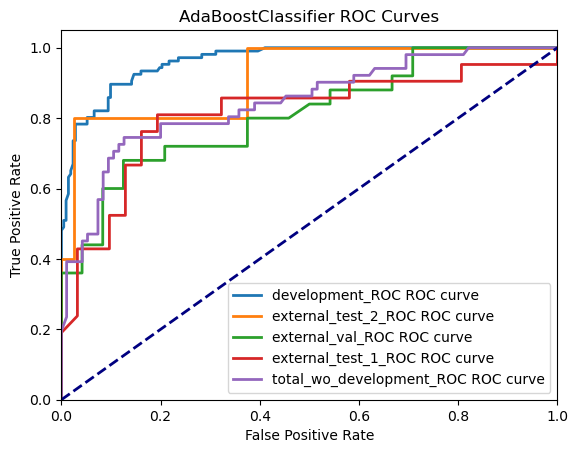

In [9]:
# Excel文件路径
file_path = './output/ROC曲线及其坐标/坐标/AdaBoostClassifier.xlsx'  # 替换为你的Excel文件路径

# 获取所有sheet的名称
sheets = pd.ExcelFile(file_path).sheet_names

# 创建绘图
plt.figure()

# 遍历每个Sheet，读取FPR和TPR并绘制ROC曲线
for sheet_name in sheets:
    # 读取每个Sheet的数据
    roc_data = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # 假设FPR在第一列，TPR在第二列
    fpr = roc_data.iloc[:, 0]
    tpr = roc_data.iloc[:, 1]
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, lw=2, label=f'{sheet_name} ROC curve')

# 添加对角线（参考线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设置坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 添加标签和标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoostClassifier ROC Curves')

# 显示图例
plt.legend(loc="lower right")

# 显示图像
plt.show()
